In [1]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sb
import os
import re
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')


In [2]:
sb.set_style("whitegrid")
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["grid.linewidth"] = 2.0
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.1
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"]= 0.9
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["figure.titlesize"] = 16
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = False
pd.options.display.max_columns = 1000

In [3]:
os.chdir("../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/MALARIA/"

In [4]:
# Esto no incluye toda las áreas del país. Sólo las áreas vistas en la base de datos de notifs.
notifs_das2depto = {
    "Escuintla": 5,
    "Alta Verapaz": 16,
    "Izabal" : 18,
    "Suchitepéquez" : 10,
    "Suchitepequez" : 10,
    "Santa Rosa" : 6,
    "Retalhuleu" : 11,
    "Petén Norte" : 17,
    "Peten Norte": 17,
    "Petén SurOccidente" : 17,
    "Petén SurOccidental" : 17,
    "Peten SurOriente" : 17,
    "Huehuetenango" : 13,
    "Quiché" : 14,
    "El Quiché": 14,
    "Petén Sur Oriental" : 17,
    "Baja Verapaz" : 15,
    "Sololá" : 7,
    "Zacapa" : 18,
    "Ixcán" : 14,
    "San Marcos" : 12,
    "Chimaltenango" : 4,
    "Guatemala Central" : 1,
    "Guatemala Sur" : 1,
    "Guatemala Nororiente" : 1,
    "Guatemala Noroccidente" : 1,
    "Ixil" : 14,
    "Jutiapa" : 22,
    "Chiquimula" : 20,
    "Ixcan" : 14,
    "El Progreso" : 2,
    "Guatemala Nororiental" : 1,
    "Quetzaltenango" : 9,
    "Jalapa": 21,
    "LNS": 1
}
code2depto = {
    5: "Escuintla",
    16:"Alta Verapaz",
    18: "Izabal",
    10: "Suchitepéquez",
    6: "Santa Rosa",
    11: "Retalhuleu",
    17: "Petén",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    7: "Sololá",
    18: "Zacapa",
    12: "San Marcos",
    4: "Chimaltenango",
    1: "Guatemala",
    22: "Jutiapa",
    20: "Chiquimula",
    2: "El Progreso",
    9: "Quetzaltenango",
    3: "Sacatepequez",
    21: "Jalapa"
}

In [5]:
bednets = pd.read_csv(base_dir + "GTM - Bednets Distr.csv", index_col = 0 , low_memory=False)
notifs = pd.read_excel(base_dir + "Base de datos 2016 - 2018 NAD.xlsx")

In [6]:
pdr = pd.read_excel(base_dir + "Movimientos MTILD y  PDR PERIODO FASE II.xls", 3, skiprows=2)
pdr.columns = ["das", 2015,2016,2017]
pdr["deptocode"] = pdr.das.apply(lambda x: notifs_das2depto.get(x.strip() if type(x) == str else "", np.NaN))
pdr = pdr.groupby("deptocode")[[2015,2016, 2017]].sum()

In [7]:
notifs.columns

Index(['AREA', 'DISTRITO', 'LOCALIDAD', 'NOMBRE', 'EDAD', 'GENERO',
       'FECHA INICIO SINTOMAS', 'FECHA TOMA DE MUESTRA',
       'FECHA RECEPCIÓN LABORATORIO', 'FECHA DE DIANÓSTICO',
       'INICIO TRATAMIENTO', 'FIN DE TRATAMIENTO', 'TIPO MALARIA',
       'SEMANA EPIDEMIOLÓGICA', 'TIPO DE MUESTRA', 'EMBARAZADA',
       'DENSIDAD PARASITARIA', 'Gametocitos', 'EMBARAZADA.1', 'Sintytom',
       'tomydiag', 'diagytrat', 'sinytrat', 'Año', 'Sintydiag'],
      dtype='object')

In [8]:
notifs = notifs[notifs.AREA.notna()]

In [9]:
def clean(x):
    try: 
        return x.strip().lower()
    except:
        return np.NaN
notifs["deptocode"] = notifs.AREA.map(str.strip).map(notifs_das2depto.get)
notifs["GENERO"] = notifs["GENERO"].apply(clean)
notifs["Gender"] = notifs.GENERO.map(lambda x: "Male" if x == "m" else "Female" if x == "f" else np.NaN)
notifs["Year"] = notifs["FECHA TOMA DE MUESTRA"].map(lambda y: y.year)

In [10]:
a = notifs.groupby(["AREA", "Year"]).apply(len).unstack(1)
a, a.sum()

(Year                   2014.0  2015.0  2016.0  2017.0  2018.0
 AREA                                                         
 Alta Verapaz              NaN   798.0   544.0   751.0   787.0
 Baja Verapaz              NaN    20.0     8.0    10.0     6.0
 Chimaltenango             NaN    11.0     3.0     2.0     1.0
 Chiquimula                NaN     3.0     1.0     2.0     9.0
 El Progreso               NaN     2.0     NaN     2.0     NaN
 Escuintla                 1.0  3585.0  3193.0  2438.0  1555.0
 Guatemala Central         NaN     1.0     5.0     6.0     5.0
 Guatemala Nororiental     NaN     1.0     2.0     1.0     NaN
 Guatemala Sur             NaN     1.0     4.0     6.0     1.0
 Huehuetenango             NaN    55.0    19.0    18.0     9.0
 Ixcan                     NaN     2.0     2.0     NaN     NaN
 Ixcán                     NaN    13.0     3.0     4.0     6.0
 Ixil                      NaN     9.0     NaN     NaN     2.0
 Izabal                    NaN   384.0   385.0   305.0 

In [11]:
notifsSemester = notifs[notifs.Year > 2014].assign(Semester = lambda x: \
                                      x["FECHA TOMA DE MUESTRA"].map(lambda y: (2 if y.month>6 else 1)))\
    .groupby(["deptocode", "Year", "Semester"]).Year.count().unstack([1,2], fill_value = 0).stack([0,1]).rename("Notifs").reset_index()
notifsSemester["semindex"] = 2*(notifsSemester.Year - 2012) + notifsSemester.Semester

In [12]:
notifsSemester[["deptocode", "semindex", "Notifs"]].set_index(["deptocode", "semindex"]).unstack(1)

Notifs                                        
semindex    7.0  8.0   9.0   10.0  11.0  12.0  13.0 14.0
deptocode                                               
1              3    0     9     2    10     3     6    0
2              1    1     0     0     1     1     0    0
4             10    1     2     1     1     1     1    0
5           2676  909  2135  1058  1418  1020  1020  535
6             53   18   115    34    29     8    10    1
7             14    2     8     2     1     0     2    0
9              1    2     0     0     0     0     1    0
10            95   57   165    76   113   187   140   83
11            75   30    44    31    24    10    13    7
12             2    6     2     1     3     4     0    0
13            33   22    13     6     9     9     5    4
14            47   16    22    10    14     8    17    8
15            15    5     6     2     4     6     2    4
16           415  383   290   254   123   628   363  424
17            66   57    82    32    50    88    86   73
18            75  316   252   142   213    99   120  142
20             3    0     1     0     1     1     8    1
21             0    0     0     0     0     0     2    0
22             2    0     1     2     1     2     4    2

In [13]:
notifsSemester.groupby(["Year", "deptocode"]).Notifs.sum().unstack(0)

Year,2015.0,2016.0,2017.0,2018.0
deptocode,,,,
1,3,11,13,6
2,2,0,2,0
4,11,3,2,1
5,3585,3193,2438,1555
6,71,149,37,11
7,16,10,1,2
9,3,0,0,1
10,152,241,300,223
11,105,75,34,20


In [14]:
bednetsSemester = bednets[(((bednets.year==2018) & (bednets.month >= 7)) == False)]\
        .assign(Semester = lambda x: x.month.map(lambda y: 2 if y > 6 else 1))\
        .groupby(["year", "Semester", "CodDepto_e"])\
         .Pabellones.sum().unstack([0,1], fill_value = 0).stack([0,1]).reset_index()
bednetsSemester["semindex"] = 2*(bednetsSemester.year - 2012) + bednetsSemester.Semester

In [18]:
bednetsSemester_m5a = bednets[(((bednets.year==2018) & (bednets.month >= 7)) == False)]\
        .assign(Semester = lambda x: x.month.map(lambda y: 2 if y > 6 else 1))\
        .groupby(["year", "Semester"])\
         .Menores5a.sum().unstack([0], fill_value = 0).stack([0]).reset_index()
bednetsSemester_m5a["semindex"] = 2*(bednetsSemester.year - 2012) + bednetsSemester.Semester

In [20]:
bednetsSemester_m5a.sort_values("year")

,Semester,year,0,semindex
0,1,2012.0,26658.0,1.0
7,2,2012.0,54694.0,8.0
1,1,2013.0,29398.0,2.0
8,2,2013.0,7724.0,9.0
2,1,2014.0,2211.0,3.0
9,2,2014.0,11997.0,10.0
3,1,2015.0,28362.0,4.0
10,2,2015.0,92261.0,11.0
4,1,2016.0,43025.0,5.0
11,2,2016.0,45631.0,12.0


In [54]:
list(range(0,15,2)), list(range(2012, 2019))

([0, 2, 4, 6, 8, 10, 12, 14], [2012, 2013, 2014, 2015, 2016, 2017, 2018])

0

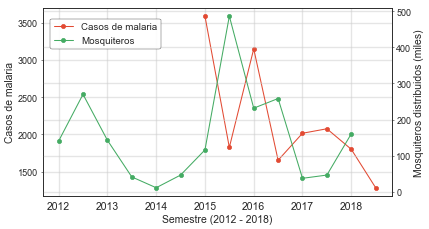

In [99]:
mlp.rcParams["figure.figsize"] = (9,5)
mlp.rcParams["figure.dpi"] = 50
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
notifsSemester.groupby("semindex").Notifs.sum().plot(label="Casos de malaria", marker="o", ax = ax1)
ax1.set_ylabel("Casos de malaria")
bednetsSemester.groupby("semindex")[0].sum().divide(1e3).plot(ax=ax2, color="#44ab63", label="Mosquiteros", marker="o")
ax2.set_ylabel("Mosquiteros distribuidos (miles)")
ax2.grid(alpha=0.5)
ax1.grid(alpha=0.5)
plt.title("")
ax1.set_xlabel("Semestre (2012 - 2018)")
plt.xticks(range(1,15,2), [2012, 2013, 2014, 2015, 2016, 2017, 2018])
fig.legend(loc='lower left', bbox_to_anchor=(0.1, 0.7))
0

In [15]:
bednetsYears = bednets\
    .groupby(["year", "CodDepto_e"]).Pabellones.sum().unstack(0).fillna(0)

In [16]:
bednetsYears

year,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
CodDepto_e,,,,,,,
2.0,0.0,0.0,0.0,5137.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,2500.0,346.0,0.0,0.0
5.0,63189.0,12661.0,25526.0,75481.0,41708.0,20000.0,17309.0
6.0,0.0,0.0,6243.0,8393.0,18250.0,0.0,0.0
7.0,0.0,0.0,0.0,6070.0,1936.0,422.0,0.0
9.0,0.0,0.0,0.0,19881.0,17263.0,446.0,4090.0
10.0,63795.0,47455.0,0.0,56722.0,69967.0,59.0,0.0
11.0,29615.0,28312.0,0.0,45595.0,37450.0,0.0,27937.0
12.0,19487.0,20463.0,50.0,25054.0,20518.0,0.0,0.0


In [17]:
bednetsSemester[bednetsSemester.CodDepto_e == 5]

,CodDepto_e,year,Semester,0,semindex
26,5.0,2012.0,1,53944.0,1.0
27,5.0,2012.0,2,9245.0,2.0
28,5.0,2013.0,1,834.0,3.0
29,5.0,2013.0,2,11827.0,4.0
30,5.0,2014.0,1,10633.0,5.0
31,5.0,2014.0,2,14893.0,6.0
32,5.0,2015.0,1,24401.0,7.0
33,5.0,2015.0,2,51080.0,8.0
34,5.0,2016.0,1,8146.0,9.0
35,5.0,2016.0,2,33562.0,10.0


# Weighted dose
As (Abrahamowicza 2005) suggests: 
$$ cum.dose(t_{current}) = \sum_{t \leq t_{current}}{dose(t) \times w(t_{current} - t)} $$

In [21]:
def weightFunction (dt, sigma):
    return( np.exp( - (dt**2)/(2* (sigma**2) ) ) )

def invWeightFunction_sigma (w, dt):
    return( np.sqrt( - (dt**2)/(2*np.log(w)) ) )

In [22]:
# for three years: 
sigma2 = invWeightFunction_sigma(0.5, 3)
print(sigma2)

2.547965400864057


In [23]:
# for three years: 
sigma3 = invWeightFunction_sigma(0.5, 6)
print(sigma3)

5.095930801728114


In [24]:
# for 5 years: 
sigma5 = invWeightFunction_sigma(0.5, 10)
print(sigma5)

8.493218002880191


In [25]:
# Calculate weights for 10 years
# for 1.5 years
w2 = [weightFunction(t, sigma2) for t in range(20,-1,-1)]
print(w2)
# for 3 years: 
w3 = [weightFunction(t, sigma3) for t in range(20,-1,-1)]
print(w3)
# for 5 years: 
w5 = [weightFunction(t, sigma5) for t in range(20,-1,-1)]
print(w5)

[4.177236667929939e-14, 8.420781453308248e-13, 1.4551915228366858e-11, 2.155720052046913e-10, 2.7375938226945685e-09, 2.98023223876953e-08, 2.781221960964482e-07, 2.224977568771586e-06, 1.5258789062500007e-05, 8.970547438205558e-05, 0.0004520872618590284, 0.001953125, 0.007233396189744457, 0.022964601441806235, 0.0625, 0.14581612994701457, 0.29163225989402913, 0.5, 0.7348672461377994, 0.9258747122872905, 1.0]
[0.0004520872618590284, 0.0009579395387391747, 0.001953125, 0.0038317581549566996, 0.007233396189744457, 0.013139006488339289, 0.022964601441806235, 0.038621702060290294, 0.0625, 0.09732059081705585, 0.14581612994701457, 0.21022410381342865, 0.29163225989402913, 0.3892823632682234, 0.5, 0.6179472329646446, 0.7348672461377994, 0.8408964152537145, 0.9258747122872905, 0.980930087668915, 1.0]
[0.0625, 0.08189958774114772, 0.10584316404531594, 0.1349035295630534, 0.16957554093095903, 0.21022410381342868, 0.2570284566640167, 0.30992692498474667, 0.36856730432277535, 0.43226861565393265,

In [26]:

bednetsSemester2 = bednetsSemester.groupby(["semindex", "CodDepto_e"])[0].sum().unstack(0).fillna(0)
cumBednets3 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets3.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w3[-i:] ) if i>0 else 0
cumBednets5 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets5.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w5[-i:] ) if i>0 else 0
cumBednets2 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets2.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w2[-i:] ) if i>0 else 0

In [27]:
cumBednets2

semindex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CodDepto_e,,,,,,,,,,,,,
2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5137.000000,4756.218397,3775.013043,2568.500000,1498.114919,749.057460
4.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2500.000000,2314.686781,2183.168115,1570.352650,983.344717,537.540325,257.154762
5.0,53944.0,59190.385480,49035.390441,46365.027201,42550.510133,44408.146292,56880.186944,95320.507102,86297.800229,97666.008596,81944.835607,67789.977136,62667.714928
6.0,0.0,0.000000,0.000000,0.000000,0.000000,6243.000000,9024.235829,12740.313784,18772.738240,24846.426703,19704.535187,13779.785182,8450.799469
7.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6070.000000,6001.059504,6368.402449,5176.719598,3494.145514,2083.829778
9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19881.000000,33056.315155,30787.034381,23571.806787,15456.324062,12895.842246
10.0,0.0,63795.000000,106219.177270,90840.626276,66828.309420,42403.109928,36677.675961,66674.238417,84404.147559,107824.897757,85075.960667,59129.005180,35962.355113
11.0,0.0,29615.000000,54331.779604,48080.233751,35880.471925,23121.503521,23176.752067,51014.194637,63341.209784,67932.813131,51686.701699,34568.875081,48191.473384
12.0,0.0,19487.000000,24703.520518,34289.609484,27467.373506,19202.469315,14348.824770,31098.600062,32515.047955,38962.593819,30059.549188,20496.909828,12281.703920


In [47]:
cum_bns_m45a = pd.Series()
for i in range(1,len(bednetsSemester_m5a)-1):
    cum_bns_m45a.loc[bednetsSemester_m5a.semindex[i] ] = np.dot( bednetsSemester_m5a[0].values[0:i], w3[-i:] ) if i>0 else 0

2.0      26658.000000
3.0      55547.634277
4.0      55730.350797
5.0      80166.317853
6.0     117204.011999
7.0     114839.262224
8.0     132376.676696
9.0     172817.460661
10.0    163343.825327
11.0    155352.172676
12.0    225915.626504
13.0    247591.797340
dtype: float64 
     Semester    year        0  semindex
0          1  2012.0  26658.0       1.0
1          1  2013.0  29398.0       2.0
2          1  2014.0   2211.0       3.0
3          1  2015.0  28362.0       4.0
4          1  2016.0  43025.0       5.0
5          1  2017.0   6439.0       6.0
6          1  2018.0  29255.0       7.0
7          2  2012.0  54694.0       8.0
8          2  2013.0   7724.0       9.0
9          2  2014.0  11997.0      10.0
10         2  2015.0  92261.0      11.0
11         2  2016.0  45631.0      12.0
12         2  2017.0   9123.0      13.0
13         2  2018.0      0.0       1.0


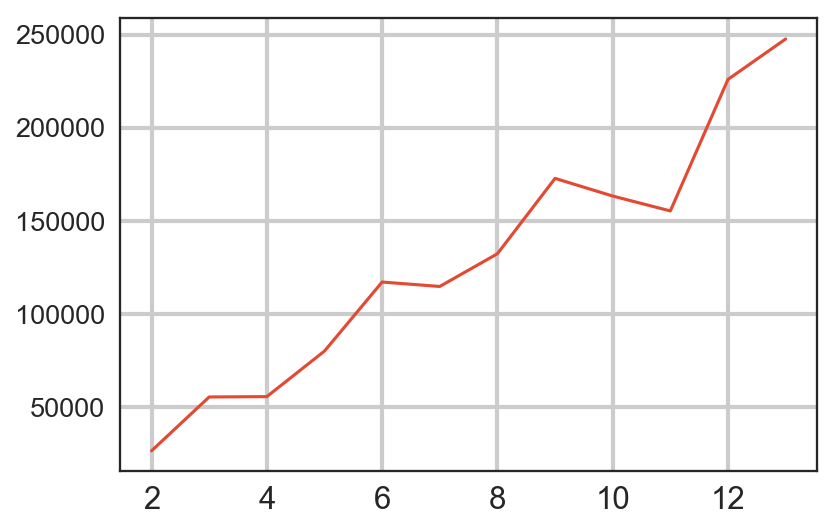

In [48]:
print(cum_bns_m45a, "\n", bednetsSemester_m5a)
plt.plot(cum_bns_m45a, label="bednets")

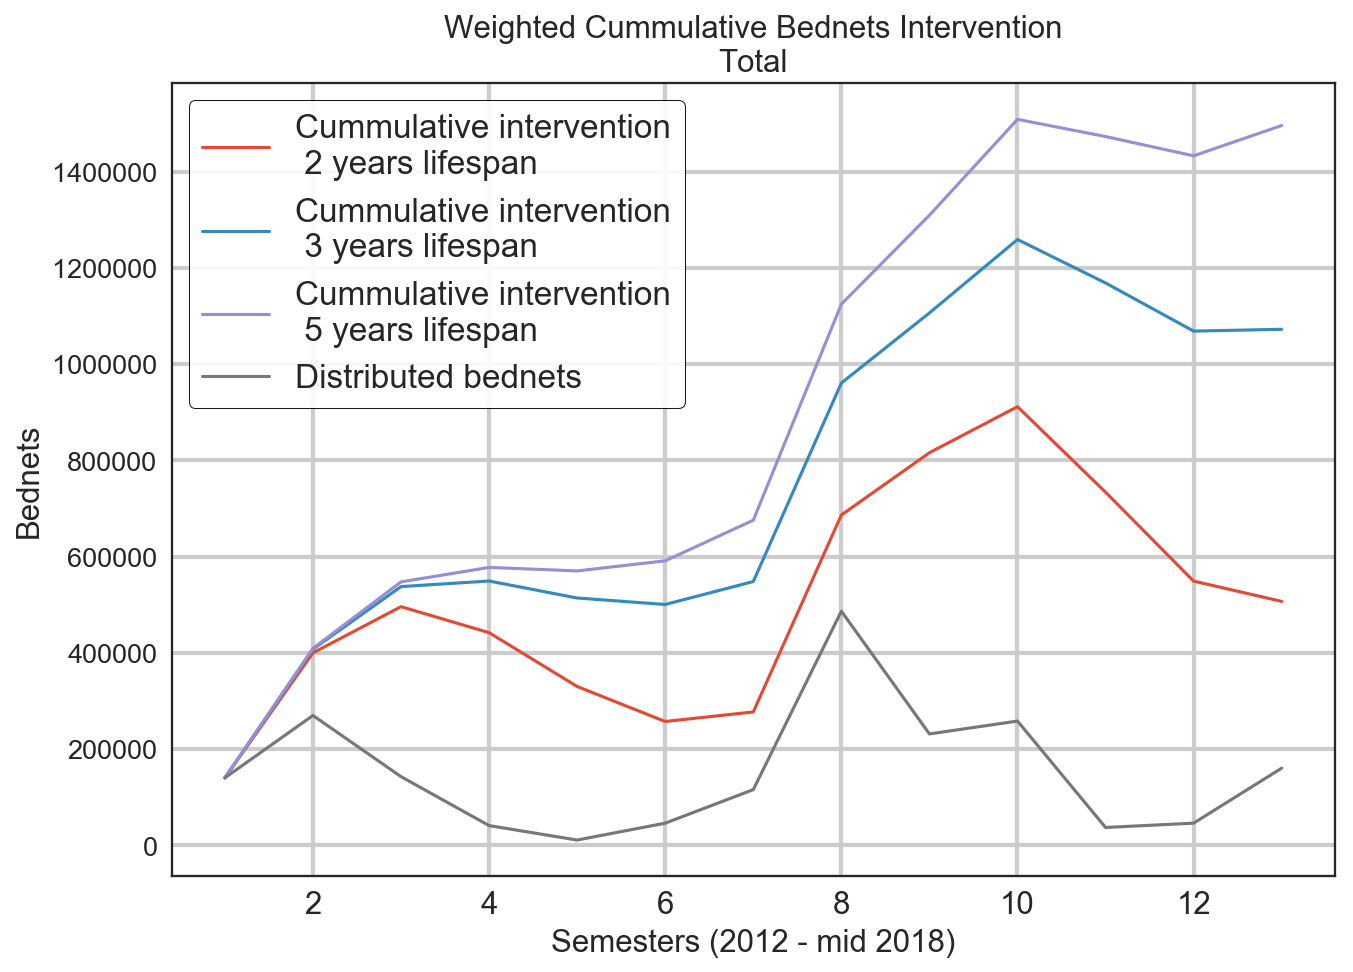

In [25]:
mlp.rcParams["figure.figsize"] = (10,7)
cumBednets2.sum().plot(label="Cummulative intervention\n 2 years lifespan")
cumBednets3.sum().plot(label="Cummulative intervention\n 3 years lifespan")
cumBednets5.sum().plot(label="Cummulative intervention\n 5 years lifespan")
bednetsSemester2.sum().plot(label="Distributed bednets")
plt.title("Weighted Cummulative Bednets Intervention\nTotal")
plt.ylabel("Bednets")
plt.xlabel("Semesters (2012 - mid 2018)")
plt.legend()

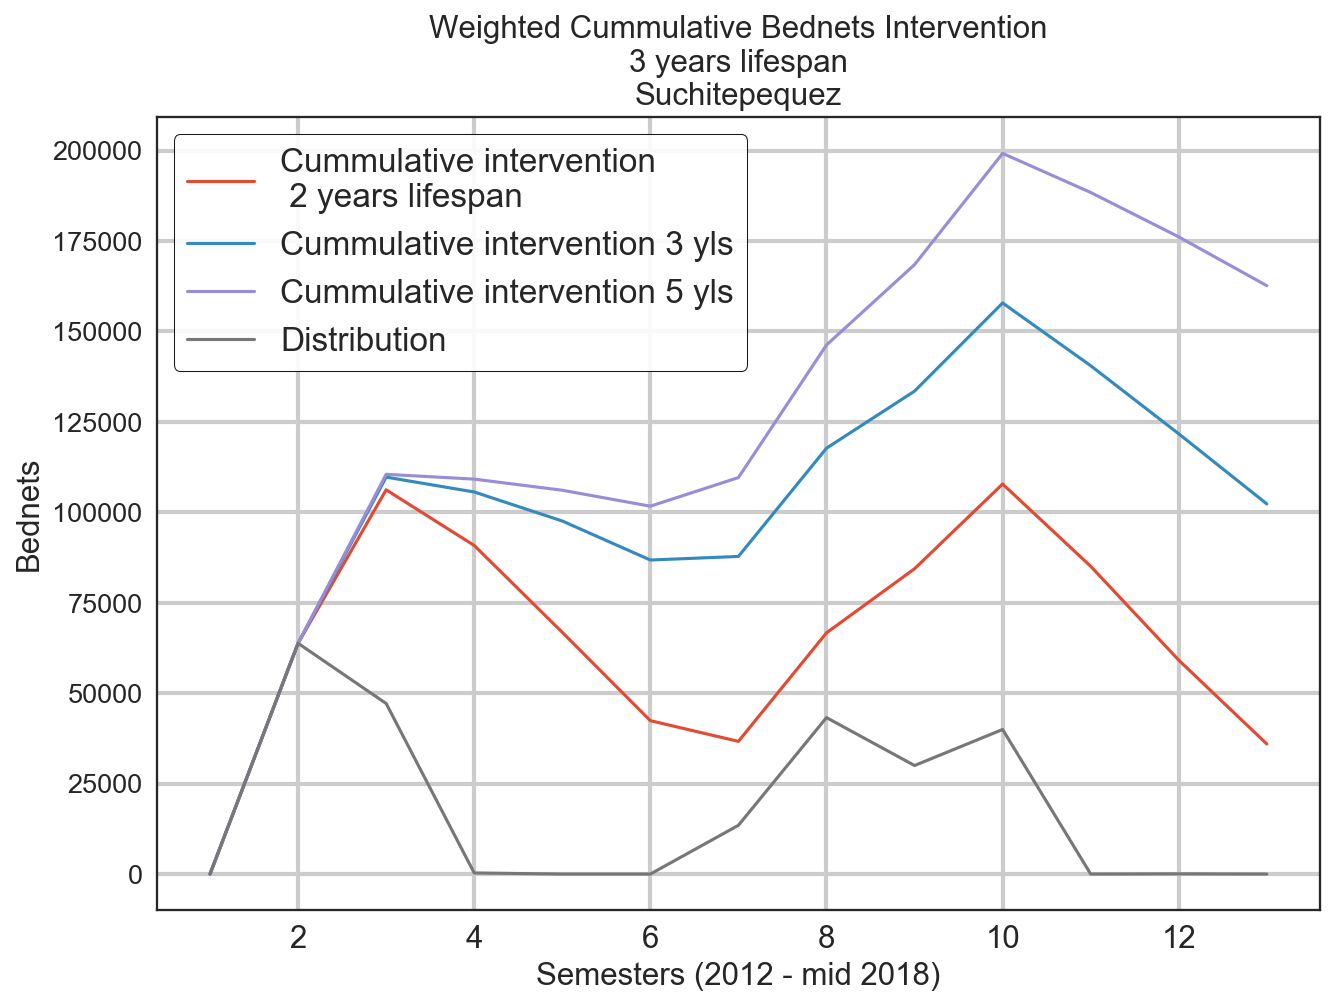

In [26]:
mlp.rcParams["figure.figsize"] = (10,7)
cumBednets2.loc[10].plot(label="Cummulative intervention\n 2 years lifespan")
cumBednets3.loc[10].plot(label="Cummulative intervention 3 yls")
cumBednets5.loc[10].plot(label="Cummulative intervention 5 yls")
bednetsSemester2.loc[10].plot(label="Distribution")
plt.title("Weighted Cummulative Bednets Intervention\n3 years lifespan\nSuchitepequez")
plt.ylabel("Bednets")
plt.xlabel("Semesters (2012 - mid 2018)")
plt.legend()

In [27]:
notifsSemester.groupby(["semindex", "deptocode"]).Notifs.sum().unstack(0).fillna(0)

semindex,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
deptocode,,,,,,,,
1,3,0,9,2,10,3,6,0
2,1,1,0,0,1,1,0,0
4,10,1,2,1,1,1,1,0
5,2676,909,2135,1058,1418,1020,1020,535
6,53,18,115,34,29,8,10,1
7,14,2,8,2,1,0,2,0
9,1,2,0,0,0,0,1,0
10,95,57,165,76,113,187,140,83
11,75,30,44,31,24,10,13,7


In [29]:
def lagBednet(i):
    def lagCalc(x):
        bednetsLag = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i))][[0]]
        bednetsLag2 = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i - 1))][[0]]
        
        if len(bednetsLag) == 1:
            return bednetsLag2.values[0][0]+bednetsLag.values[0][0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["bednetsLagSem_"+str(i)] = notifsSemester.apply(lagBednet(i), axis = 1)

In [31]:
def lagNotifs(i):
    def lagCalc(x):
        notifsLag = notifsSemester[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))].Notifs
        if len(notifsLag) == 1:
            return notifsLag.values[0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["notifsLagSem_"+str(i)] = notifsSemester.apply(lagNotifs(i), axis = 1)

In [32]:
# Clean notifs semester dataframe
notifsSemester = notifsSemester\
        [[x for x in notifsSemester.columns if ( (not x.endswith("_y")) & (not x.endswith("_x")) &
         (not x.startswith("cumBN") ))]]

notifsSemester = notifsSemester.merge(cumBednets3.stack().rename("cumBN").reset_index(), how="left",
                     left_on=["deptocode", "semindex"],
                    right_on = ["CodDepto_e", "semindex"])
notifsSemester.loc[notifsSemester["cumBN"].isna() ,"cumBN"] = 0

In [33]:
def lagCol(i, col, df):
    def lagCalc(x):
        cumLag = df[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))][col]
        if len(cumLag) == 1:
            return cumLag.values[0]
        else:
            return 0
    return lagCalc

In [34]:
for i in range(1,5):
    notifsSemester["cumBNLagSem_"+str(i)] = notifsSemester.apply(lagCol(i, "cumBN", notifsSemester), axis = 1)

In [35]:
notifsSemester.semindex.value_counts()

14.0    19
13.0    19
12.0    19
11.0    19
10.0    19
9.0     19
8.0     19
7.0     19
Name: semindex, dtype: int64

In [36]:
notifsSemester.to_csv(base_dir + "Gtm Malaria impact analysis data.csv")